In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scaling_lib.ftutils_torch as ftutils
import matplotlib.pyplot as plt

In [2]:
from scaling_lib.split_step_solver import BPMSplitStepSolver
from scaling_lib.waveguide import Waveguide
from scaling_lib.helpers import smoothen1d, gaussian_beam, add_absorbing_boundary, timestring, L2, has_converged
from scaling_lib.mode_solver import solve_modes
from scaling_lib.pat import make_pat_func
from scaling_lib import pnn_utils 

# Main

In [43]:
Nmodes = 10

# waveguide parameters
λ0 = 1.55 # free-space wavelength, all lengths are in um
k0 = 2*np.pi/λ0
neff = 1.8 # effective index of slab mode

# x-axis
Lx = 500 # width of simulation area (transverse dimension)
Nx = 2**9 # number of pixels in transverse dimensions
dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

# z-axis
dz = 10 # propagation step in z-direction
Lz = 10000 # length of device in propagation-direction
Nz = int(np.floor(Lz/dz))
z_axis = (torch.arange(Nz)+1)*dz

# mode properties
mode_x_min = -150 # center position of leftmost mode
mode_x_max = 150 # center position of rightmost mode
mode_sigma = 10 # standard deviation of gaussian mode

# training parameters
delta_n_val = 10e-3 # maximal refractive index change
seed = 1 # seed used when sampling random unitary
iterations = 100 # number of training epochs
lr = 0.5e-1 # learning rate
device = 'cuda'

In [80]:
# Define the background delta n of the multimode waveguide
# Since we want to simulate a slab waveguide, we set the real part of background_delta_n to zero
# and add absorbing boundary conditions
background_delta_n = torch.zeros(Nx, dtype = torch.complex64)
background_delta_n = add_absorbing_boundary(x_axis, background_delta_n, k0, abs_width=50, sigma_max = 0.001)
# The waveguide class is just a convenient way of storing all parameters associated with the waveguide
# It doesn't do anything beyond that
wg = Waveguide(neff, x_axis, z_axis, background_delta_n, device = device)

Text(0.5, 1.0, 'Flat index profile (slab waveguide)')

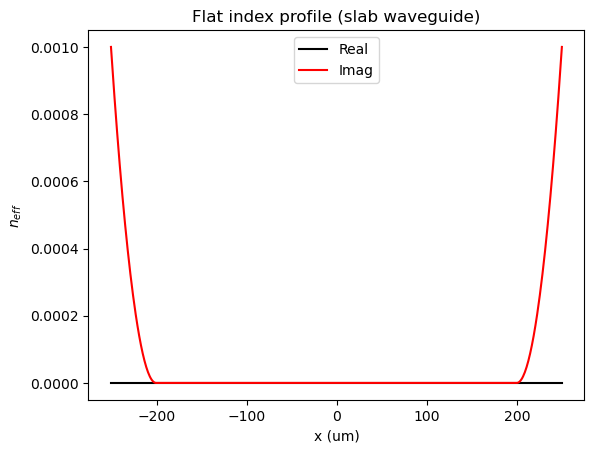

In [81]:
plt.plot(x_axis, background_delta_n.real, c='k', label = 'Real')
plt.plot(x_axis, background_delta_n.imag, c='r', label = 'Imag')
plt.xlabel('x (um)')
plt.ylabel(r'$n_{eff}$')
plt.legend()
plt.title('Flat index profile (slab waveguide)')

In [82]:
# We use Gaussian beams as our "modes"
modes = torch.vstack([gaussian_beam(x_axis, mu, mode_sigma) for mu in np.linspace(mode_x_min, mode_x_max, Nmodes)])

Text(0.5, 1.0, 'Waveguide modes')

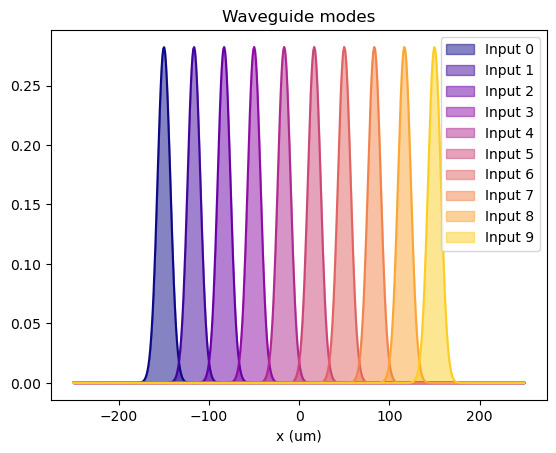

In [83]:
import matplotlib.cm as cm

for ind_mode, mode in enumerate(modes):
    plt.fill_between(x_axis, mode, label = f'Input {ind_mode}', color = cm.plasma(ind_mode/Nmodes), alpha = 0.5)
    plt.plot(x_axis, mode, color = cm.plasma(ind_mode/Nmodes))

plt.legend(loc = 'upper right')
plt.xlabel('x (um)')
plt.title('Waveguide modes')

In [84]:
# Set up the split step solver which will integrate the PDE
bpmsolver = BPMSplitStepSolver(x_axis, z_axis, neff)

# Inverse design

## Set up mismatched forward-backward pass

In [85]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, modes, device, mode = 'insilico', wg_backward = None):
        super(TDwgNet, self).__init__()
        self.device = device
        
        mod = torch.zeros([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[-0.45, 0.45]) 
        self.delta_n_val = delta_n_val
        
        self.input_modes = modes.to(dtype=torch.complex128).to(self.device)
        self.output_modes = modes.to(dtype=torch.complex128).to(self.device)
        
        self.wg = wg
        self.solver = solver
        
        if wg_backward: self.wg_backward = wg_backward
        else: self.wg_backward = wg
            
        if mode == 'pat': self.f_pat = make_pat_func(self.forward_internal, self.backward_internal)
        if mode == 'insilico': self.f_pat = self.forward_internal

    def forward(self, x):
        a_out = self.f_pat(x, self.mod)
        return a_out

    def forward_internal(self, x, mod):
        mod = mod.clip(0, 1)

        inputs = x.to(self.device) @ self.input_modes

        # artificial misalignment of input beams
        inputs_misaligned = torch.roll(torch.eye(Nmodes, dtype=torch.complex128, device = device)@tdwg_pnn.input_modes, inds_misalignment, dims = -1)
        
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        output_beams = self.solver.run_simulation(inputs_misaligned, delta_n)
        
        a_out = output_beams@self.output_modes.T*dx
        return a_out
        
    def backward_internal(self, x, mod):
        mod = mod.clip(0, 1)

        inputs = x.to(self.device) @ self.input_modes
        
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        output_beams = self.solver.run_simulation(inputs, delta_n)
        
        a_out = output_beams@self.output_modes.T*dx
        return a_out

In [86]:
tdwg_pnn = TDwgNet(bpmsolver, wg, delta_n_val, modes, device, mode = 'pat')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Nominal vs misaligned inputs')

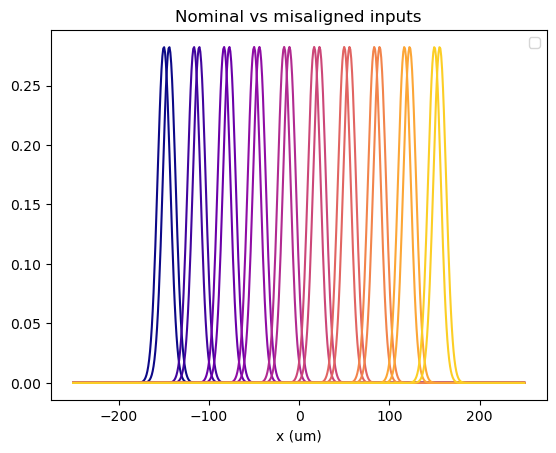

In [87]:
inds_misalignment = wg.x2ind(6)-wg.x2ind(0)
inputs = torch.eye(Nmodes, dtype=torch.complex128, device = device)@tdwg_pnn.input_modes
inputs_misaligned = torch.roll(torch.eye(Nmodes, dtype=torch.complex128, device = device)@tdwg_pnn.input_modes, inds_misalignment, dims = -1)

for ind_mode, mode in enumerate(modes):
    plt.plot(x_axis, inputs[ind_mode].cpu(), color = cm.plasma(ind_mode/Nmodes))
    plt.plot(x_axis, inputs_misaligned[ind_mode].cpu(), color = cm.plasma(ind_mode/Nmodes))

plt.legend(loc = 'upper right')
plt.xlabel('x (um)')
plt.title('Nominal vs misaligned inputs')

In [88]:
def run_training_loop(tdwg_pnn, U_target, iterations, lr, batch_size, device, gamma=0.99, print_interval=1):
    optimizer = optim.Adam(tdwg_pnn.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    U_target = U_target.to(device)
    loss_list = []
    
    n = len(tdwg_pnn.input_modes)  # length of the original vector
    indices = np.arange(n)
    batch_indices = np.array_split(indices, np.ceil(n / batch_size))  # Split into subvectors

    tdwg_pnn.train()
    for i in range(iterations):
        optimizer.zero_grad()

        for indices in batch_indices:
            U_num = tdwg_pnn.forward(torch.eye(n, dtype = torch.complex128)[indices])
            l_objective = L2(U_target[indices], U_num)
    
            l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp = 1, factor = 20)
            l = l_objective + l_lagrange 
            # l = l_objective
            l.backward()
            
        optimizer.step()
        scheduler.step()
        loss_list.append(l.detach().cpu().data)

        if i % print_interval == 0:
            print(timestring() + f"--Iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
            # get_cpu_memory_usage(threshold_gb = 0.01)
            # get_gpu_memory_usage(threshold_gb = 0.01)
        if has_converged(loss_list):
            print(timestring() + f"Converged at iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
            break
    return loss_list

In [89]:
from scipy.stats import unitary_group

In [90]:
U_target = unitary_group.rvs(Nmodes, random_state=seed)
U_target = torch.tensor(U_target, device = device)

In [91]:
loss_list = run_training_loop(tdwg_pnn, U_target, iterations, lr, batch_size = 10, device = device, print_interval=20)

2025-09-22--16-59-14--Iteration: 0, Loss: 0.67667
2025-09-22--16-59-26--Iteration: 20, Loss: 0.11959
2025-09-22--16-59-37--Iteration: 40, Loss: 0.04079
2025-09-22--16-59-50--Iteration: 60, Loss: 0.02453
2025-09-22--16-59-51Converged at iteration: 63, Loss: 0.02429


Text(0, 0.5, 'Loss')

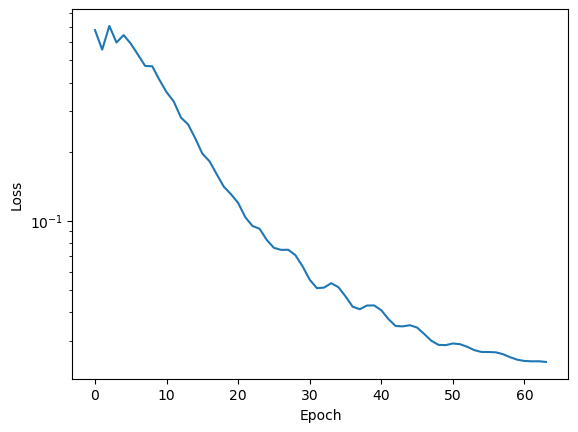

In [92]:
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [93]:
with torch.no_grad():
    U_num_inv = tdwg_pnn(torch.eye(Nmodes, dtype = torch.complex128))

In [94]:
avg_error_inv = torch.mean(torch.abs(U_num_inv-U_target))/torch.mean(torch.abs(U_target)) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 19.01%


## Plot inverse design results

In [95]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (3, 1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="coolwarm", vmax=vmax, vmin=-vmax)
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$\Delta n(x, z)$")

    visible_ticks = [tick for tick in ax.get_xticks() if ax.get_xlim()[0] <= tick <= ax.get_xlim()[1]]
    visible_ticks = [0] + visible_ticks  # Add 0 to the visible ticks
    ax.set_xticks(visible_ticks)

    # Create a separate figure for the colorbar
    fig_cbar = plt.figure(figsize=(0.1, figsize_deltan[1]))
    cbar = plt.colorbar(img, cax=plt.gca())
    cbar.set_label(r'$\Delta n$', rotation=270, labelpad=5)  # Reduced labelpad from 15 to 5
    
    # Display both figures
    plt.show()

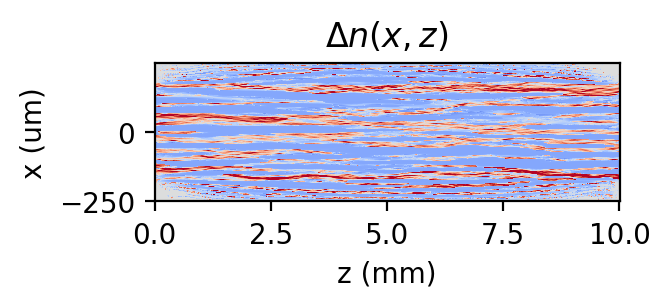

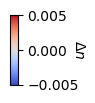

In [97]:
delta_n_inv = delta_n_val*(torch.clip(tdwg_pnn.mod.detach().cpu(), -0.5, 0.5))
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, delta_n_val/2)

In [98]:
vmax = U_target.abs().max()

In [99]:
def plot_unitary(U, vmax, title, colorbar_flag=True):
    figsize_U = (1.3, 1.3)
    
    # Plot main figure
    fig_main, ax = plt.subplots(figsize=figsize_U, dpi=200)
    img = plt.imshow(np.abs(U), cmap="bone_r", vmax=vmax)
    plt.title(title)
    plt.xticks([0, 2, 4, 6, 8])
    
    if colorbar_flag:
        # Create a separate figure for the colorbar
        fig_cbar = plt.figure(figsize=(0.1, figsize_U[1]))
        cbar = plt.colorbar(img, cax=plt.gca())
    
    # Display figures
    plt.show()

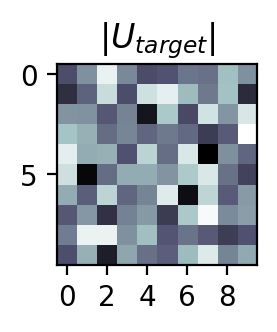

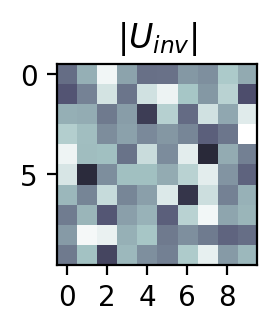

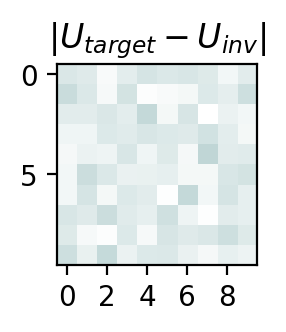

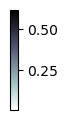

In [102]:
plot_unitary(U_target.cpu(), vmax, r"$|U_{target}|$", colorbar_flag=False)
plot_unitary(U_num_inv.cpu(), vmax, r"$|U_{inv}|$", colorbar_flag=False)
plot_unitary(torch.abs(U_num_inv-U_target).cpu(), vmax, r"$|U_{target}-U_{inv}|$", colorbar_flag=True)